In [1]:
import pandas as pd
import numpy as np
from time import process_time
import ast
import re
import regex
import csv
from string import punctuation
from nltk.stem import WordNetLemmatizer
import unicodedata
from collections import OrderedDict 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

%matplotlib notebook

# Read and Preprocess data

In [17]:
class Preprocess:
        
    # --------------------------------------- Constructor ------------------------------------------------

    def __init__(self):
        file = open("../marathi-stopwords.txt")
        self.stopword_list = []
        for row in file:
            self.stopword_list.append(re.sub('\n', '', row))


    # --------------------------------------- Clean Data -------------------------------------------------    
    
    def read_data(self, path):
        return pd.read_csv(path)

    
   # --------------------------------------- Expand Concatenations --------------------------------------- 
        
    def expand_concatenations(self, word):            
        if not re.match('[a-zA-Z]+', word) or re.match('\d+',word):
            for i in range(len(word)):
                if not('DEVANAGARI ' in unicodedata.name(word[i])):
                    word = word[:i] if( len(word[i:]) < 2 and not word[i:].isnumeric()) else word[:i] + " " + word[i:]
                    break
        else:
            for i in range(len(word)):
                if ('DEVANAGARI ' in unicodedata.name(word[i])):
                    word = word[i:] if( len(word[:i]) < 2 and not word[:i].isnumeric() ) else word[:i] + " " + word[i:]
                    break
        return(word)


    # --------------------------------------- Preprocess --------------------------------------- 

    def preprocess_data(self, text: str) -> str:
        try:
            if not(isinstance(text, str)): text = str(text)

            #Removing unprintable characters
            text = ''.join(x for x in text if x.isprintable())

            # Cleaning the urls
            text = re.sub(r'https?://\S+|www\.\S+', '', text)

            # Cleaning the html elements
            text = re.sub(r'<.*?>', '', text)

            # Removing the punctuations
            text = re.sub('[!#?,.:";-@#$%^&*_~<>()-]', '', text)


            # Removing stop words
            text = ' '.join([word for word in text.split() if word not in self.stopword_list])

            # Expanding noisy concatenations (Eg: algorithmआणि  -> algorithm आणि ) 
            text = ' '.join([self.expand_concatenations(word) for word in text.split()])

            preprocessed_text = ""

            for word in text.split(): 
                if (re.match('\d+', word)):
                    if(word.isnumeric()):
                        preprocessed_text = preprocessed_text + '#N' + " "
                else:
                    if(re.match('[a-zA-Z]+', word)):
                        if not len(word) < 2:
                            preprocessed_text = preprocessed_text + word.lower() + " "
                    else:
                        preprocessed_text = preprocessed_text + word + " "

            return preprocessed_text.strip()

        except ValueError as ve:
            print('Error processing:\t',text)
            return ''

In [18]:
obj = Preprocess()

In [19]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = obj.read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [21]:
x_train = training_data.text.apply(lambda x: obj.preprocess_data(x)).values.tolist()

In [22]:
y_train = training_data.label.values.tolist()

In [23]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = obj.read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [24]:
x_val = val_data.text.apply(lambda x: obj.preprocess_data(x)).values.tolist()
y_val = val_data.label.values.tolist()

# Tokenize Data

In [25]:
def tokenize_text(x_train, x_val):
    tokenizer = Tokenizer(oov_token='[OOV]')
    tokenizer.fit_on_texts(x_train)
    x_train_tokenized = tokenizer.texts_to_sequences(x_train)
    x_val_tokenized = tokenizer.texts_to_sequences(x_val)
    return tokenizer, x_train_tokenized, x_val_tokenized

In [26]:
tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(x_train, x_val)
print(len(x_train_tokenized))
print(len(x_val_tokenized))

41997
3780


In [27]:
vocab = tokenizer.word_index
vocab_words = vocab.keys()

In [33]:
def analyze_vocab(vocab_words):
    numbers = []
    english_words = []
    marathi_words = []
    for word in vocab_words:
        if any(map(str.isdigit, word)):
        #if re.match('\d+', word):
            numbers.append(word)
        elif re.match('[a-zA-Z]+', word):
            english_words.append(word)
        else:
            marathi_words.append(word)
    return numbers, english_words, marathi_words

In [34]:
print("Total Vocabulary: ", len(vocab_words))
numbers, english_words, marathi_words = analyze_vocab(vocab_words)
print(len(numbers))
print(len(english_words))
print(len(marathi_words))

Total Vocabulary:  51801
0
909
50892


In [30]:
for word in numbers:
        print(word)

xv6
x86
r1
r2
co2
p1
ec2
q10
p3
p2
s2
w1
x2go
cr3
v1
p4
s1
s3
f1
w2
x1
v2
w3
t1
dom0
x2
a2
ffff0
k2
w4
t1z
h2
t2
tio2
rω2
d1
application1
k1et
cr0
r3
f210t2
m1
m2
mrω2
q1
nσ2
i386
if30
into100
dom4j
v2p
p12
d121
eg1
eg2
x11
i7
a1
b1
k3
g1
g2
g3
g4
vtrω2g
s12
av1
w3c
d2
ec2s
x100
k1
by6into100
num1
x68
minus2
y2
p2v
raid1
raid2
raid5
logf1logf2
logf1f2
x7felf
v4
v9
h2o
c6h12o6
o2
mixtimes100
n2σ2
cd1
alv1
t15
e210
c4


In [32]:
for t, d in list(zip(x_train, training_data.text.values.tolist())):
    for w in t.split():
        if w in numbers:
            print(t)
            print(d, "\n")

ऑब्जेक्ट फाईल x86 #N बिट मशीन्ससाठी दर्शविते नंतर पाहिले प्रकरणात एंट्री पॉइंट #N
तर , हा ऑब्जेक्ट फाईल x86 - 64 बिट मशीन्ससाठी आहे , हे दर्शविते , नंतर आपण पाहिले आहे की या प्रकरणात एंट्री पॉइंट 0 आहे . 

प्रत्यक्षात वितरण s1 वर्ग भगिले सिग्मा #N वर्ग भगिले s2 वर्ग सिग्मा #N वर्ग
म्हणजे प्रत्यक्षात F वितरण s1 वर्ग भगिले सिग्मा 1 वर्ग भगिले s2 वर्ग सिग्मा 2 वर्ग . 

प्रत्यक्षात वितरण s1 वर्ग भगिले सिग्मा #N वर्ग भगिले s2 वर्ग सिग्मा #N वर्ग
म्हणजे प्रत्यक्षात F वितरण s1 वर्ग भगिले सिग्मा 1 वर्ग भगिले s2 वर्ग सिग्मा 2 वर्ग . 

x86 प्रणालीमध्ये #N प्रकारचे डिस्क्रिप्टर टेबल असतात
x86 प्रणालीमध्ये 2 प्रकारचे डिस्क्रिप्टर टेबल असतात . 

क्षेत्रांच्या छेदनबिंदारास चतुर्भुज चौकोन दर्शवित ज्याने संसाधन r1 विनंती करणार्या दोन्ही प्रक्रियांमध्ये निर्देशांचे अनुकरण
म्हणून , या दोन क्षेत्रांच्या छेदनबिंदारास हे चतुर्भुज चौकोन दर्शवित आहे ज्याने संसाधन R1 विनंती करणार्या दोन्ही प्रक्रियांमध्ये निर्देशांचे अनुकरण केले आहे . 

q10 लक्षात ठेवा प्रक्रिया संरक्षणाच्या अधिकारानुसार लक्षात ठेवून अतिशय चा

पुढे पॅकेजिंग युनिट पाहुया x86 प्रणालीमध्ये वर्च्युअल मेमरी मॅपिंग आवश्यकरित्या व्यवस्थापित करते
पुढे आपण पॅकेजिंग युनिट पाहुया जे x86 प्रणालीमध्ये वर्च्युअल मेमरी मॅपिंग आवश्यकरित्या व्यवस्थापित करते . 

जर तापमान असेल उत्पादन चांगले असेल q10 थेट
जर तापमान कमी असेल तर उत्पादन चांगले असेल की Q10 थेट येथे येत आहे . 

r1 प्लस #N बरोबर दुसरी ओळ r1 असेल नंतर r1 मेमरीमध्ये परत येईल
म्हणजे ती R1 प्लस 1 बरोबर दुसरी ओळ R1 असेल आणि नंतर R1 मेमरीमध्ये परत येईल . 

r1 प्लस #N बरोबर दुसरी ओळ r1 असेल नंतर r1 मेमरीमध्ये परत येईल
म्हणजे ती R1 प्लस 1 बरोबर दुसरी ओळ R1 असेल आणि नंतर R1 मेमरीमध्ये परत येईल . 

r1 प्लस #N बरोबर दुसरी ओळ r1 असेल नंतर r1 मेमरीमध्ये परत येईल
म्हणजे ती R1 प्लस 1 बरोबर दुसरी ओळ R1 असेल आणि नंतर R1 मेमरीमध्ये परत येईल . 

आवश्यक नसलेल्या पॅकेजेस काढा जसे मला x11 किंवा विंडोज मॅनेजर इत्यादि इत्यादिची गरज
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

जर पाहू d1 त्याचे w1 w2 w4 d2 गोष्टी मोजते
तर , जर आपण पाहू की d1 , तर त्याचे w1 , w2 , w4 आहे ; d2 हे या गोष्टी आहेत आणि हे मोजते . 

जर पाहू d1 त्याचे w1 w2 w4 d2 गोष्टी मोजते
तर , जर आपण पाहू की d1 , तर त्याचे w1 , w2 , w4 आहे ; d2 हे या गोष्टी आहेत आणि हे मोजते . 

जर पाहू d1 त्याचे w1 w2 w4 d2 गोष्टी मोजते
तर , जर आपण पाहू की d1 , तर त्याचे w1 , w2 , w4 आहे ; d2 हे या गोष्टी आहेत आणि हे मोजते . 

जर पाहू d1 त्याचे w1 w2 w4 d2 गोष्टी मोजते
तर , जर आपण पाहू की d1 , तर त्याचे w1 , w2 , w4 आहे ; d2 हे या गोष्टी आहेत आणि हे मोजते . 

जर पाहू d1 त्याचे w1 w2 w4 d2 गोष्टी मोजते
तर , जर आपण पाहू की d1 , तर त्याचे w1 , w2 , w4 आहे ; d2 हे या गोष्टी आहेत आणि हे मोजते . 

आपणास अशा परिस्थितीत जावे लागेल जिथे आपल्याला माहित शहरे देश वातावरणात co2 च्या वाढीच्या परिणामास सामोरे जाऊ शकत नाहीत खरोखरच ठीक गंभीरपणे संबोधित
आपणास अशा परिस्थितीत जावे लागेल जिथे आपल्याला माहित आहे की शहरे आणि देश वातावरणात CO2 च्या वाढीच्या परिणामास सामोरे जाऊ शकत नाहीत , जे खरोखरच ठीक आहे म्हणून ते गंभीरपणे संबोधित क

xv6 मध्ये तयार केलेल्या प्रत्येक प्रक्रियेस विशिष्ट अर्रेमध्ये प्रविष्टी असेल
म्हणून , xv6 मध्ये तयार केलेल्या प्रत्येक प्रक्रियेस या विशिष्ट अर्रेमध्ये एक प्रविष्टी असेल . 

म्हणूनच सामान्यपणे ऍमेझॉन ईसी #N सेवा एचपी हायपरवाइजर वापरुन जर xen हायपरवाइजर माफ करा xen हायपरवाइजरकडे पहात असाल dom0 आम्ही विशेषाधिकारित वर्च्युअल मशीन अतिथी प्रतिमांचे व्यवस्थापन करते भाग भौतिक संसाधने प्रवेश नियंत्रण अधिकार अतिथी प्रतिमांमधील मार्ग पॅकेटवर कॉन्फिगर करते स्वतः अहवाल देते ट्रेस मार्ग उजवीकडे हॉप
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - म्हणूनच , सामान्यपणे ऍमेझॉन ईसी 2 सेवा एचपी हायपरवाइजर वापरुन आणि जर आपण XEN हायपरवाइजर  माफ करा ; तर आपण XEN हायपरवाइजरकडे पहात असाल तर येथे Dom0 आहे जे आम्ही विशेषाधिकारित वर्च्युअल मशीन आहे जे अतिथी प्रतिमांचे व्यवस्थापन करते काय भाग आहे , ते भौतिक संसाधने प्रवेश नियंत्रण अधिकार त्याच्या अतिथी प्रतिमांमधील मार्ग पॅकेटवर कॉन्फिगर करते आणि स्वतः

तुम्ही एक्सक्लोजरच्या विशेष कोडमध्ये xv6 सोर्स कोड मध्ये देखील पाहू शकता exec dot
आणि तुम्ही त्या एक्सक्लोजरच्या विशेष कोडमध्ये xv6 सोर्स कोड मध्ये देखील पाहू शकता , exec dot c . 

चला x86 किंवा intel x86 प्रोसेसर कशा प्रकारे विकसित प्रारंभ करूया
तर , चला , x86 किंवा Intel x86 प्रोसेसर कशा प्रकारे विकसित झाले याचा प्रारंभ करूया . 

चला x86 किंवा intel x86 प्रोसेसर कशा प्रकारे विकसित प्रारंभ करूया
तर , चला , x86 किंवा Intel x86 प्रोसेसर कशा प्रकारे विकसित झाले याचा प्रारंभ करूया . 

प्रत्येक मॅपर शब्दाच्या अंशत w1 w2 w3 अशा प्रकारच्या शब्दाची गणना करते
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - तर , प्रत्येक मॅपर शब्दाच्या अंशत : w1 , w2 , w3 आणि अशा प्रकारच्या शब्दाची गणना करते . 

प्रत्येक मॅपर शब्दाच्या अंशत w1 w2 w3 अशा प्रकारच्या शब्दाची गणना करते
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

विशिष्ट वस्तू #N mb विशिष्ट बिंदू किंवा विशिष्ट पत्ता प्रथम भौतिक पत्ता पत्ता बसमध्ये cpu द्वारे ठेवले ffff0 विशिष्ट #N mb च्या खाली #N बाइट
म्हणून , 0x12345 ही विशिष्ट वस्तू 1 MB आहे हा विशिष्ट बिंदू किंवा या विशिष्ट पत्ता आणि प्रथम भौतिक पत्ता जो पत्ता बसमध्ये CPU द्वारे ठेवले आहे तो ffff0 आहे जे या विशिष्ट 1 MB च्या खाली 16 बाइट आहे . 

याव्यतिरिक्त p1 p2 p3 p4 #N कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात
याव्यतिरिक्त , P1 , P2 , P3 आणि P4 15 कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात . 

याव्यतिरिक्त p1 p2 p3 p4 #N कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात
याव्यतिरिक्त , P1 , P2 , P3 आणि P4 15 कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात . 

याव्यतिरिक्त p1 p2 p3 p4 #N कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात
याव्यतिरिक्त , P1 , P2 , P3 आणि P4 15 कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात . 

याव्यतिरिक्त p1 p2 p3 p4 #N कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात
याव्यतिरिक्त , P1 , P2 , P3 आणि P4 15 कळा नंतर पुन्हा तयार रांगेत पुन्हा पोहोचतात . 

पृष्ठ निर्देशिका विशेष सार

In [42]:
for word in numbers:
    print(word)

5
०
००
१
४


# Get Word-Embeddings

In [14]:
def get_embedding_dict(embedding_path, vocab):
    embedding_dict = dict()
    vocab_words = set(vocab.keys())
    embedding_file = open(embedding_path, 'r')
    for row in embedding_file:
        row = row.split()
        word = row[0].strip()
        wv = np.asarray(row[1:], dtype='float32')
        if len(wv) == 300:
            embedding_dict[word] = wv
    return embedding_dict

In [15]:
embedding_path_ft = "/home/eastwind/word-embeddings/fasttext/cc.mr.300.vec"
embedding_dict_ft = get_embedding_dict(embedding_path_ft, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ft))

845805


In [16]:
embedding_path_indic = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_dict_indic = get_embedding_dict(embedding_path_indic, bow_vectorizer.vocabulary_)
print(len(embedding_dict_indic))

258413


In [17]:
embedding_path_ds = "/home/eastwind/word-embeddings/fasttext/TechDofication.ft.skipgram.mr.epoch50.d300.vec"
embedding_dict_ds = get_embedding_dict(embedding_path_ds, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ds))

51962


In [18]:
ft_words = [x for x in embedding_dict_ft.keys()]
indic_words = [x for x in embedding_dict_indic.keys()]
ds_words = [x for x in embedding_dict_ds.keys()]
word_list = bow_vectorizer.get_feature_names()

In [19]:
print("Fasttext Vocabulary: ", len(ft_words))
print("\nIndic-Fasttext Vocabulary: ", len(indic_words))
print("\nDS-Fasttext Vocabulary: ", len(ds_words))

Fasttext Vocabulary:  845805

Indic-Fasttext Vocabulary:  258413

DS-Fasttext Vocabulary:  51962


# Get Union and Interseciton

In [20]:
union1 = set(ft_words) | set(indic_words)
print("Fasttext and Indic-fasttext union Vocabulary: ", len(union1))
union2 = set(ft_words) | set(ds_words)
print("\nFasttext and DS-fasttext union Vocabulary: ", len(union2))
union3 = set(indic_words) | set(ds_words)
print("\nIndic-fasttext and DS-fasttext union Vocabulary: ", len(union3))
union= set(ft_words) | set(indic_words) | set(ds_words)
print("\nFasttext, Indic-fasttext, and DS-fasttext union Vocabulary: ", len(union))

Fasttext and Indic-fasttext union Vocabulary:  903109

Fasttext and DS-fasttext union Vocabulary:  864982

Indic-fasttext and DS-fasttext union Vocabulary:  281086

Fasttext, Indic-fasttext, and DS-fasttext union Vocabulary:  921416


In [21]:
with open("vocabulary/ft-ds-union.txt", "w") as outfile:
    outfile.write("\n".join(union2))

In [22]:
with open("vocabulary/indic-ds-union.txt", "w") as outfile:
    outfile.write("\n".join(union3))

In [23]:
intersect1 = set(ft_words) & set(indic_words)
print("Fasttext and Indic-fasttext interesction Vocabulary: ", len(intersect1))
intersect2 = set(ft_words) & set(ds_words)
print("\nFasttext and DS-fasttext interesction Vocabulary: ", len(intersect2))
intersect3 = set(indic_words) & set(ds_words)
print("\nIndic-fasttext and DS-fasttext interesction Vocabulary: ", len(intersect3))
intersect= set(ft_words) & set(indic_words) & set(ds_words)
print("\nFasttext, Indic-fasttext, and DS-fasttext interesction Vocabulary: ", len(intersect))

Fasttext and Indic-fasttext interesction Vocabulary:  201109

Fasttext and DS-fasttext interesction Vocabulary:  32785

Indic-fasttext and DS-fasttext interesction Vocabulary:  29289

Fasttext, Indic-fasttext, and DS-fasttext interesction Vocabulary:  28419


In [24]:
with open("vocabulary/ft-ds-intersection.txt", "w") as outfile:
    outfile.write("\n".join(intersect2))

In [25]:
with open("vocabulary/indic-ds-intersection.txt", "w") as outfile:
    outfile.write("\n".join(intersect3))

# Visualize Embeddings

In [26]:
def visualize_embeddings(words, embeddings):
        vectors = []
    
        # convert both lists into numpy vectors for reduction
        embeddings = np.asarray(embeddings)
        words = np.asarray(words)

        vectors = np.asarray(vectors)
        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        vectors = tsne_model.fit_transform(embeddings)
        print(vectors.shape)

        x = []
        y = []
        for value in vectors:
            x.append(value[0])
            y.append(value[1])

        plt.figure() 
        
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(words[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
       
        plt.show()

In [27]:
words = []
embeddings = []

word = "देशांचा"
embeddings.append(embedding_dict_ft[word])
words.append("fasttext")
embeddings.append(embedding_dict_indic[word])
words.append("indic-fasttext")
embeddings.append(embedding_dict_ds[word])
words.append("DS-fasttext")

(3, 2)


<IPython.core.display.Javascript object>


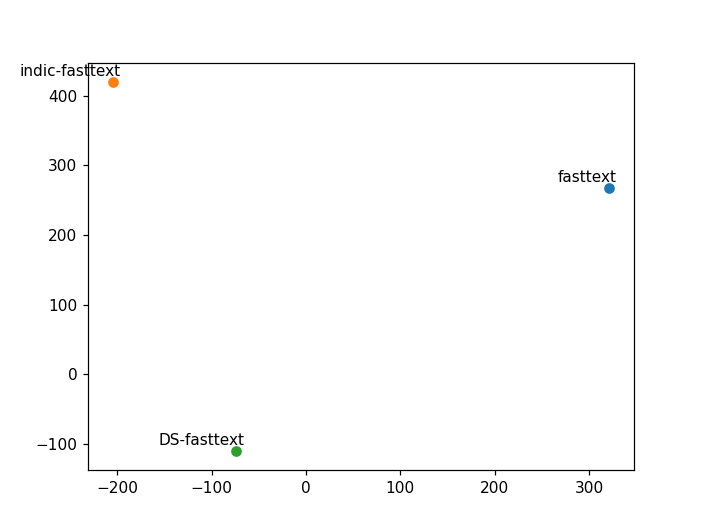

In [28]:
visualize_embeddings(words, embeddings)

In [29]:
for word in intersect:
    embeddings.append(embedding_dict_ft[word])
    words.append("fasttext")
    embeddings.append(embedding_dict_indic[word])
    words.append("indic-fasttext")
    embeddings.append(embedding_dict_ds[word])
    words.append("DS-fasttext")

(15, 2)


<IPython.core.display.Javascript object>


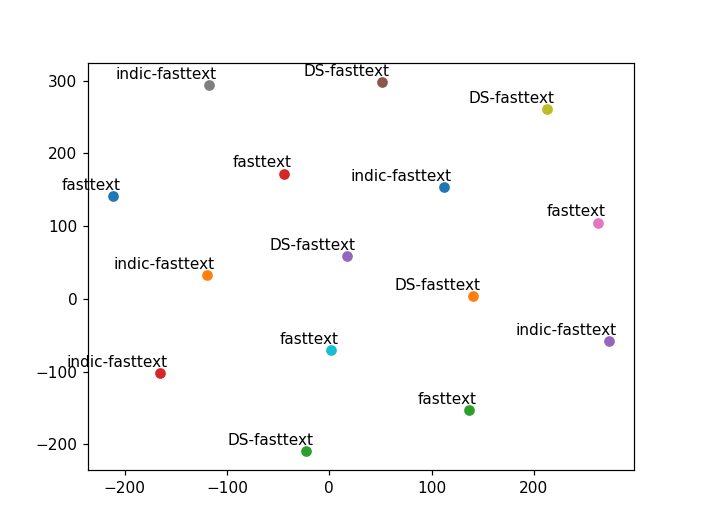

In [30]:
visualize_embeddings(words[:15], embeddings[:15])

In [36]:
def analyze_vocab(vocab_words):
    numbers = []
    english_words = []
    marathi_words = []
    for word in vocab_words:
        #if any(map(str.isdigit, word)):
        if re.match('\d+', word):
            numbers.append(word)
        elif re.match('[a-zA-Z]+', word):
            english_words.append(word)
        else:
            marathi_words.append(word)
    return numbers, english_words, marathi_words

In [37]:
vocab_words = bow_vectorizer.get_feature_names()

In [38]:
print("Total Vocabulary: ", len(vocab_words))
numbers, english_words, marathi_words = analyze_vocab(vocab_words)
print(len(numbers))
print(len(english_words))
print(len(marathi_words))

Total Vocabulary:  51774
17
881
50876


In [40]:
embeddings = []
words = []
for word in numbers:
    embeddings.append(embedding_dict_ds[word])
    words.append("DS-fasttext")

(17, 2)


<IPython.core.display.Javascript object>


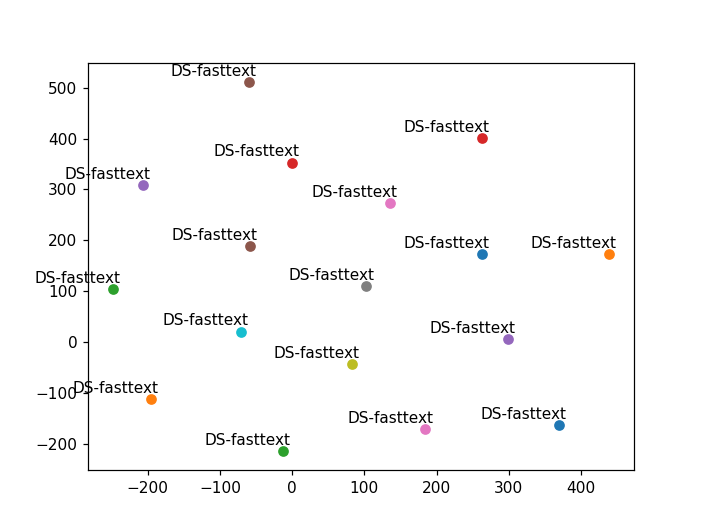

In [41]:
visualize_embeddings(words, embeddings)

In [44]:
char = []
domain = []
reason = []
spcl_words = ['ºC', 'δδ', 'δδt', 'δवाढतो,' 'ε', 'εi', 'ηi', 'ρ', 'σ', 'σD', 'σμ', 'ω']

for text, label in list(zip(x_train, y_train)):
    for x in text.split():
        if x in english_words:
            domain.append(label)
            char.append(x)
            reason.append('english')
        elif x in numbers:
            domain.append(label)
            char.append(x)
            reason.append('number')
        elif x in spcl_words:
            domain.append(label)
            char.append(x)
            reason.append('spcl_char')
        

df = pd.DataFrame(list(zip(reason, char, domain)), columns=['reason', 'char', 'domain'])
df

,reason,char,domain
0,english,z,bioche
1,english,z,bioche
2,english,ram,cse
3,english,p,cse
4,english,unambiguously,cse
...,...,...,...
3704,english,xml,cse
3705,english,linux,cse
3706,english,ms,cse
3707,english,dos,cse


In [45]:
df[df.reason == 'english'].domain.value_counts()

cse         2262
com_tech     861
phy          367
bioche       152
Name: domain, dtype: int64

In [46]:
df[df.reason == 'number'].domain.value_counts()

phy         30
com_tech    15
bioche       2
Name: domain, dtype: int64

In [47]:
df[df.reason == 'spcl_char'].domain.value_counts()

com_tech    9
cse         6
bioche      3
phy         2
Name: domain, dtype: int64

In [72]:
embeddings = []
words = []
temp = df[df.reason == 'spcl_char']
spcl_words = temp[temp.domain == 'cse'].char.values.tolist()

for word in spcl_words:
    embeddings.append(embedding_dict_ds[word])
    words.append(word)
print(len(words))

6


(6, 2)


<IPython.core.display.Javascript object>


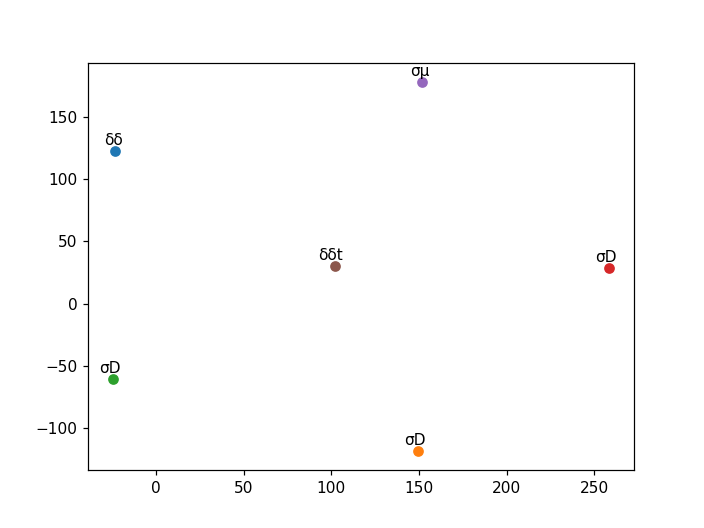

In [73]:
visualize_embeddings(words, embeddings)